# Sudoku 4 Points

## Packages

In [116]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import os
import re
import cv2

In [117]:
torch.randint(0, 200, (1, 4))[0]

tensor([165, 122,  50, 114])

## Dataset

In [118]:
# Custom Dataset Loader
class SudokuDataset(Dataset):
    def __init__(self, transform=None, augmentation=None, target_transform=None):
        self.dir = './sudoku_dataset/'
        self.filenames = self.extract_filenames()
        self.transform = transform
        self.augmentation = augmentation
        self.target_transform = target_transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        path = os.path.join(self.dir, self.filenames[idx])

        img = cv2.imread(path+'.jpg')
        
        with open(path+'.4pt', 'r') as file:
            label = file.readline()

        label = [float(i) for i in label.split()]
        label=torch.tensor(label)
        label = torch.reshape(label, (-1, 2))

        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.GaussianBlur(img, (7, 7), 0)
        img = cv2.adaptiveThreshold(img, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 4)
        img = torch.from_numpy(img)
        img = img[None, :, :]

        pad = tuple(torch.randint(0, 300, (1, 4))[0].tolist())
        img = nn.functional.pad(img, pad,'constant', 0)
        
        label[:, 0] += pad[0]
        label[:, 1] += pad[2]
        
        _, h, w = img.shape

        label[:, 0] /= w
        label[:, 1] /= h

        label = torch.flatten(label)

        
        if self.transform:
            img = self.transform(img)

        if self.augmentation:
            img = self.augmentation(img)

        if self.target_transform:
            label = self.target_transform(label)
        
        return img, label

    def extract_filenames(self):
        filenames = []
        with open('./sudoku_dataset/mixed/filenames_4pt', 'r') as file:
            img_list = file.readlines()
        filenames += [re.search('(.*)\.jpg', i).group(1) for i in img_list]

        return filenames

# Basic Preprocessor
transforms = v2.Compose([
    v2.Resize(size=(400, 400)),
    v2.ToDtype(torch.float32, scale=True)
])

# Basic Preprocessor
target_transforms = v2.Compose([
    v2.ToDtype(torch.float32, scale=True)
])

# Data Augmenter
augmentation = v2.Compose([
    v2.RandomAdjustSharpness(sharpness_factor=5),
    v2.RandomAutocontrast(p=0.5)
])

In [119]:
training_data = SudokuDataset(transforms, augmentation, target_transforms)

train_dataloader = DataLoader(training_data, batch_size=16, shuffle=True)

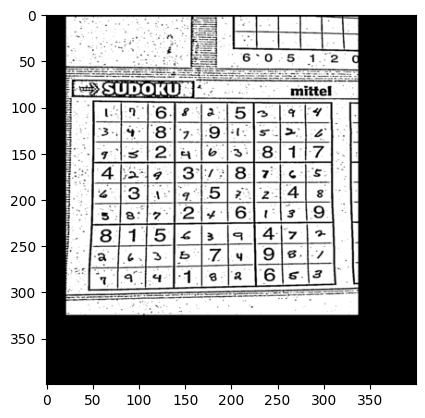

In [120]:
train_features, train_labels = next(iter(train_dataloader))

plt.imshow(torch.reshape(train_features[0], (400,400)), cmap='gray')
# plt.imshow(train_features[0], cmap='gray')


In [121]:
def plt_points(img, points):
    points = points.detach().clone()
    points *= 400
    points = torch.reshape(points, (-1, 2))

    img = torch.reshape(img, (400, 400))
    
    # Create figure and axes
    fig, ax = plt.subplots()
    
    # Display the image
    ax.imshow(img, cmap='gray')
    
    # Plot points on the image
    for idx, point in enumerate(points):
        x, y = point
        ax.plot(x, y, 'rx')  # 'ro' means red color, circular marker
    
        # Add text label next to the point
        ax.text(x, y, f'({idx})', color='red', fontsize=8, ha='right', va='bottom')
    
    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    # Show the plot"
    plt.show()

torch.Size([8])
torch.Size([1, 400, 400])


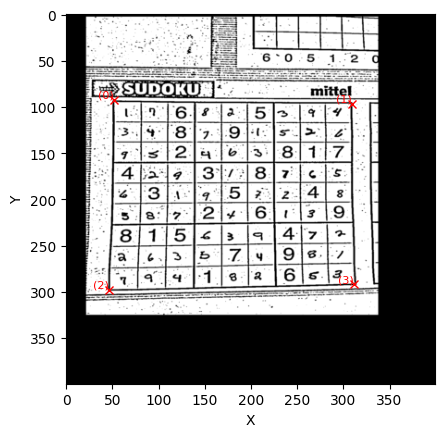

In [122]:
print(train_labels[0].shape)

print(train_features[0].shape)

plt_points(train_features[0], train_labels[0])

## Modeling

In [136]:
# Straightforward CNN

class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, padding='same')
        torch.nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2 = nn.Conv2d(4, 8, 3, padding='same')
        torch.nn.init.kaiming_normal_(self.conv2.weight)    
        self.conv3 = nn.Conv2d(8, 4, 3, padding='same')
        torch.nn.init.kaiming_normal_(self.conv3.weight) 
        self.conv4 = nn.Conv2d(4, 1, 3, padding='same')
        torch.nn.init.kaiming_normal_(self.conv4.weight)
        self.fc1 = nn.Linear(625, 300)
        torch.nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(300, 150)
        torch.nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(150, 75)
        torch.nn.init.kaiming_normal_(self.fc3.weight)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(75, 30)
        torch.nn.init.kaiming_normal_(self.fc4.weight)
        self.dropout4 = nn.Dropout(0.2)
        
        self.fc5 = nn.Linear(30, 8)
        torch.nn.init.kaiming_normal_(self.fc5.weight)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, inp):
        x = self.pool(F.relu(self.conv1(inp)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x

def cnn1_loss(pred, target):

    # Perform crossentropy loss on every 10 units batch
    loss_fn = nn.MSELoss()

    return loss_fn(pred, target)

## Training

In [137]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [138]:
cnn1 = CNN1().to(device)
print(cnn1)

CNN1(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=625, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=75, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=75, out_features=30, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=30, out_features=8, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
)


In [139]:
ALPHA=0.001
optimizer = torch.optim.Adam(cnn1.parameters(), lr=ALPHA)

def train_step(epoch_idx, model, loss_fn):
    for idx, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        loss.backward()
        optimizer.step()    
        optimizer.zero_grad()

    with torch.no_grad():
        running_loss = 0
        for idx, data in enumerate(train_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            pred = model(inputs)
            loss = loss_fn(pred, labels)
            running_loss += loss

        avg_loss = running_loss / (idx + 1)
        
        print(f"Epoch {epoch_idx}:\nTraining Loss: {avg_loss}") 
        
    return avg_loss

In [140]:
losses = []
cnn1.train()
for i in range(250):
    loss = train_step(i, cnn1, cnn1_loss)
    losses.append(loss)

Epoch 0:
Training Loss: 0.030231205746531487
Epoch 1:
Training Loss: 0.02315347082912922
Epoch 2:
Training Loss: 0.01951267197728157
Epoch 3:
Training Loss: 0.015401969663798809
Epoch 4:
Training Loss: 0.014315818436443806
Epoch 5:
Training Loss: 0.011380687355995178
Epoch 6:
Training Loss: 0.010036720894277096
Epoch 7:
Training Loss: 0.008328680880367756
Epoch 8:
Training Loss: 0.008117472752928734
Epoch 9:
Training Loss: 0.007573734503239393
Epoch 10:
Training Loss: 0.006735255476087332
Epoch 11:
Training Loss: 0.005805165972560644
Epoch 12:
Training Loss: 0.007128956262022257
Epoch 13:
Training Loss: 0.00542198121547699
Epoch 14:
Training Loss: 0.005605642683804035
Epoch 15:
Training Loss: 0.004983027931302786
Epoch 16:
Training Loss: 0.006000072695314884
Epoch 17:
Training Loss: 0.004835390951484442
Epoch 18:
Training Loss: 0.004482080694288015
Epoch 19:
Training Loss: 0.004668590147048235
Epoch 20:
Training Loss: 0.004417862743139267
Epoch 21:
Training Loss: 0.0039040737319737673


In [141]:
cnn1.eval()

CNN1(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=625, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=75, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc4): Linear(in_features=75, out_features=30, bias=True)
  (dropout4): Dropout(p=0.2, inplace=False)
  (fc5): Linear(in_features=30, out_features=8, bias=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
)

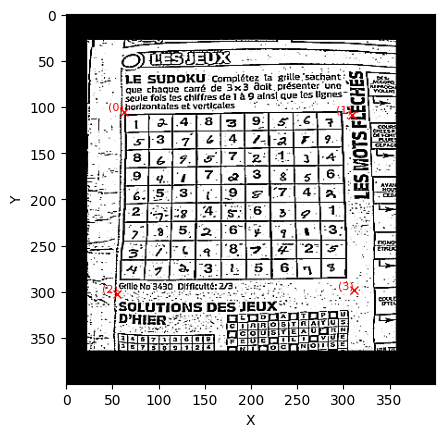

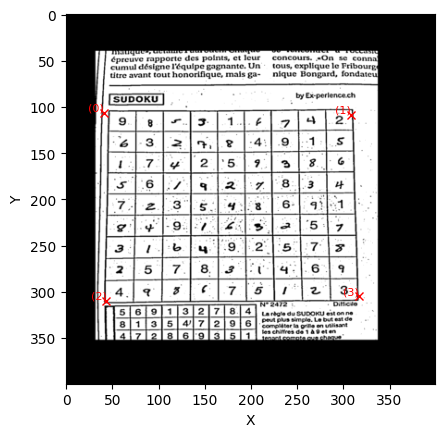

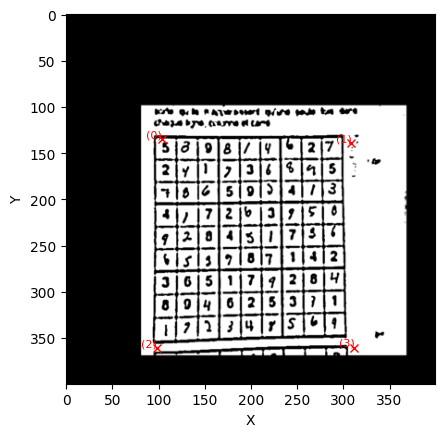

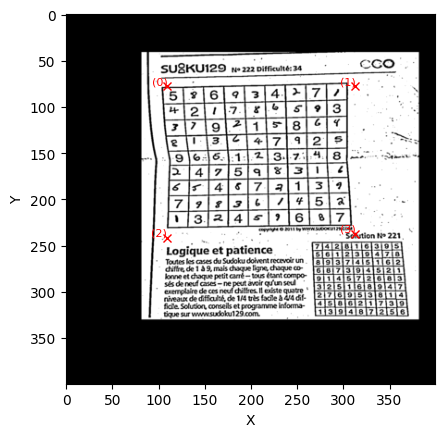

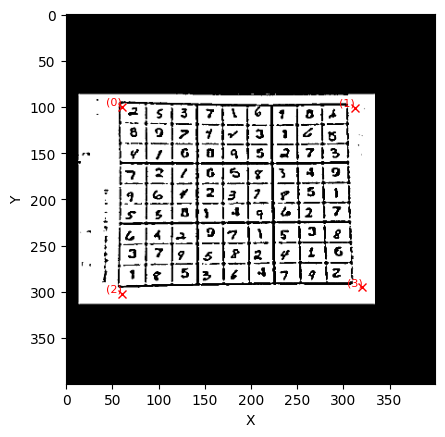

In [142]:
for idx, data in enumerate(train_dataloader):
    with torch.no_grad():
        inputs, labels = data
        inputs = inputs.to(device)
        pred = cnn1(inputs)
        for i in range(1):
            plt_points(torch.Tensor.cpu(inputs[i]), torch.Tensor.cpu(pred[i]))

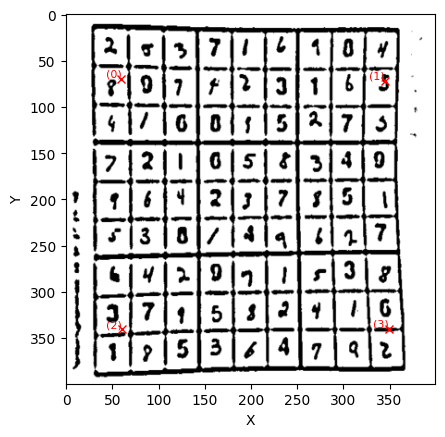

In [143]:
## Testing
test_img_path = './sudoku_dataset/mixed/image1.jpg'

# test_img_path = './test.png'

def preprocess_img(path):
    img = cv2.imread(path)            
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (7, 7), 0)
    img = cv2.adaptiveThreshold(img, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 4)
    img = torch.from_numpy(img)
    img = img[None, :, :]
    img = transforms(img)
    return img

img = preprocess_img(test_img_path)
with torch.no_grad():
    input = img.to(device)
    pred = cnn1(input)
    plt_points(torch.Tensor.cpu(input[0]), torch.Tensor.cpu(pred[0]))

I gave up on this approach, because it seems kind of complicated for the neural network to learn and I have very few datasets.

I have manually annotatad about 60 images. :D